In [1]:
from pymove import maputils, trajutils
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import mplleaflet as mpl

In [3]:
import dask.dataframe as dd
#import modin.pandas as mp
import pandas as pd

# 1. Read and presentation of the data 

In [5]:
filename = '/Users/nickssonarrais/datasets/tnz/Compress/tnz2019_01_full_integration.csv.zip'
usecols=[0, 1, 2, 3]

In [7]:
compression = filename.split('.')[-1]
n_rows = ''
if compression == 'gz':
    n_rows = !zcat {filename} | wc -l
    compression = 'gzip'
elif compression == 'zip':
    n_rows = !zcat {filename} | wc -l
elif compression == 'csv':
    n_rows = !cat {filename} | wc -l

#n_rows = int(n_rows[0])
print("rows: {}".format(n_rows))

rows: ["zcat: can't stat: /Users/nickssonarrais/datasets/tnz/Compress/tnz2019_01_full_integration.csv.zip (/Users/nickssonarrais/datasets/tnz/Compress/tnz2019_01_full_integration.csv.zip.Z): No such file or directory", '       0']


In [8]:
n_rows

["zcat: can't stat: /Users/nickssonarrais/datasets/tnz/Compress/tnz2019_01_full_integration.csv.zip (/Users/nickssonarrais/datasets/tnz/Compress/tnz2019_01_full_integration.csv.zip.Z): No such file or directory",
 '       0']

In [6]:
if compression == 'csv':
    !head {filename}
    compression = None
elif compression == 'gzip':
    !gzip -cd {filename} | head

id,datetime,lat,lon
M00038,2019-06-01 00:33:08,-3.76126,-38.51268
M00038,2019-06-01 00:34:08,-3.76127,-38.51263
M00038,2019-06-01 00:35:08,-3.76125,-38.51264
M00038,2019-06-01 00:36:08,-3.76128,-38.51264
M00038,2019-06-01 00:41:08,-3.76125,-38.51261
M00038,2019-06-01 00:43:08,-3.76123,-38.51258
M00038,2019-06-01 00:44:08,-3.76125,-38.5126
M00038,2019-06-01 00:45:08,-3.76129,-38.51258
M00038,2019-06-01 00:46:08,-3.76122,-38.51257

gzip: stdout: Broken pipe


In [30]:
names = ['id', 'datetime', 'lat', 'lon']
dtype = {'lat':'float32', 'lon':'float32'}
parse_dates= ['datetime']
header=1

In [31]:
df = pd.read_csv(filename, dtype=dtype, parse_dates=parse_dates)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623117 entries, 0 to 2623116
Data columns (total 25 columns):
id                      object
segment_stop            object
datetime                object
lat                     float32
lon                     float32
stop                    bool
event_id                int64
event_type              object
dist_cvp                float64
Home                    float64
Delegacias              float64
Praças e Parques        float64
Ponto de Ônibus         float64
Posto de Combustível    float64
Supermercados           float64
Bancos                  float64
Hospital                float64
Farmácia                float64
Loja de Bicicleta       float64
Loja de Eletrônicos     float64
Oficinas                float64
Courthouse              float64
Forum                   float64
police                  float64
Presidio                float64
dtypes: bool(1), float32(2), float64(17), int64(1), object(4)
memory usage: 462.8+ MB


In [18]:
df.sort_values(['id', 'datetime'], inplace=True)

### Test pandasql

In [22]:
import pandasql as pdsql

In [23]:
pysql = lambda q: pdsql.sqldf(q, globals())

In [25]:
#pysql('select * from df limit 5')

In [26]:
df.head()

,id,segment_stop,datetime,lat,lon,stop,event_id,event_type,dist_cvp,Home,...,Bancos,Hospital,Farmácia,Loja de Bicicleta,Loja de Eletrônicos,Oficinas,Courthouse,Forum,police,Presidio
0,M00038,1,2019-06-01 00:01:08,-3.76128,-38.512562,False,4636487,ROUBO DE VEÍCULO,4694.654,5.615985,...,876.001277,985.981317,594.763013,813.104325,181.362425,315.824056,1378.026735,3245.412483,442.072751,15364.061617
1,M00038,1,2019-06-01 00:33:08,-3.76126,-38.512680,False,4636550,ROUBO TENTATIVA,15505.423,16.821225,...,888.151605,994.751707,592.274345,819.471294,191.805575,317.405298,1364.703808,3243.865334,452.741893,15366.924510
2,M00038,1,2019-06-01 00:34:08,-3.76127,-38.512630,False,4636550,ROUBO TENTATIVA,15510.877,11.480145,...,882.976611,991.066752,593.440501,816.828681,187.349410,316.788706,1370.417263,3244.657080,448.051960,15365.559815
3,M00038,1,2019-06-01 00:35:08,-3.76125,-38.512642,False,4636550,ROUBO TENTATIVA,15509.696,12.552038,...,883.830565,990.810965,591.184583,816.001520,187.596726,315.085850,1368.837573,3242.508056,450.717194,15367.861996
4,M00038,1,2019-06-01 00:36:08,-3.76128,-38.512642,False,4636550,ROUBO TENTATIVA,15509.564,13.276701,...,884.745708,992.960637,594.554415,818.658503,189.229053,318.312885,1368.936773,3245.873438,448.257684,15364.494760


# 2. processing

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2623117 entries, 0 to 2623116
Data columns (total 25 columns):
id                      object
segment_stop            object
datetime                object
lat                     float32
lon                     float32
stop                    bool
event_id                int64
event_type              object
dist_cvp                float64
Home                    float64
Delegacias              float64
Praças e Parques        float64
Ponto de Ônibus         float64
Posto de Combustível    float64
Supermercados           float64
Bancos                  float64
Hospital                float64
Farmácia                float64
Loja de Bicicleta       float64
Loja de Eletrônicos     float64
Oficinas                float64
Courthouse              float64
Forum                   float64
police                  float64
Presidio                float64
dtypes: bool(1), float32(2), float64(17), int64(1), object(4)
memory usage: 482.8+ MB


#### Create index to trajectory

In [32]:
trajutils.create_update_tid_based_on_id_datatime(df, str_format='%Y%m%d')


Creating or updating tid feature...

...Sorting by id and datetime to increase performance


...tid feature was created...



In [ ]:
%%time
trajutils.segment_trajectory_by_dist_time_speed(df, label_id='id', max_dist_between_adj_points=3000,
    max_time_between_adj_points=7200, max_speed_between_adj_points=50.0, drop_single_points=True)

#### Create dist, time and speed

In [54]:
trajutils.create_update_dist_time_speed_features(df, sort=True)

Creating or updating distance, time and speed features in meters by seconds
...Sorting by id and datetime to increase performance
...Set id as index to a higher peformance
(2761/2623117) 0% in 00:00:02.757 - estimated end in 00:43:37.445
(526879/2623117) 20% in 00:00:02.821 - estimated end in 00:00:11.224
(1053548/2623117) 40% in 00:00:02.874 - estimated end in 00:00:04.282
(1574090/2623117) 60% in 00:00:02.928 - estimated end in 00:00:01.951
(2100727/2623117) 80% in 00:00:03.006 - estimated end in 00:00:00.747
(2623117/2623117) 100% in 00:00:03.066 - estimated end in 00:00:00.000
...Reset index...

Total Time: 3.17 seconds
-----------------------------------------------------



In [37]:
#df[df['tid_part'] == 1]

###### Create a date feature

In [38]:
%%time
df['date'] = df['datetime'].dt.date

CPU times: user 774 ms, sys: 32.7 ms, total: 806 ms
Wall time: 813 ms


# 3. Analysis of the entire dataset

### 3.1 Amount of trajectories

###### 3.1.1 Total Trajectories

In [39]:
df.sort_values(['tid'], ascending=True, inplace=True)

In [ ]:
del df['tid']

##### 3.1.2 Count the number of trajectories for each id

In [40]:
df_amount = df.loc[:,['id', 'tid']].groupby(['tid','id']).count().reset_index().groupby(['id']).count().reset_index().sort_values(['tid'], ascending=False).reset_index()
df_amount.shape[0]
# to save in csv
#df_amount.to_csv('amount_trajectories_to_each_id.csv', index=False)

597

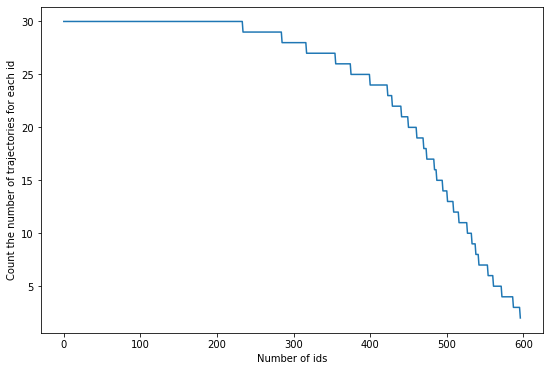

In [41]:
plt.figure(figsize=(9, 6))
plt.plot(df_amount['tid'])
plt.ylabel('Count the number of trajectories for each id')
plt.xlabel('Number of ids')
name = 'Count the number of trajectories for each id'
plt.savefig(name+'.png',dpi=400)

In [42]:
df_id_foreach_date = df.loc[:,['date', 'id']].groupby(['id','date']).count().reset_index().groupby(['date']).count().reset_index().sort_values(['date'], ascending=False)
df_id_foreach_date.head()
# to save in csv
#df_id_foreach_date.to_csv('amount_trajectories_by_date_to_all_id.csv', index=False)

,date,id
29,2019-06-30,532
28,2019-06-29,468
27,2019-06-28,492
26,2019-06-27,497
25,2019-06-26,480


In [43]:
df_id_foreach_date.set_index(['date'], inplace=True)

In [44]:
df_id_foreach_date.sort_values(['date'], ascending=True, inplace=True)

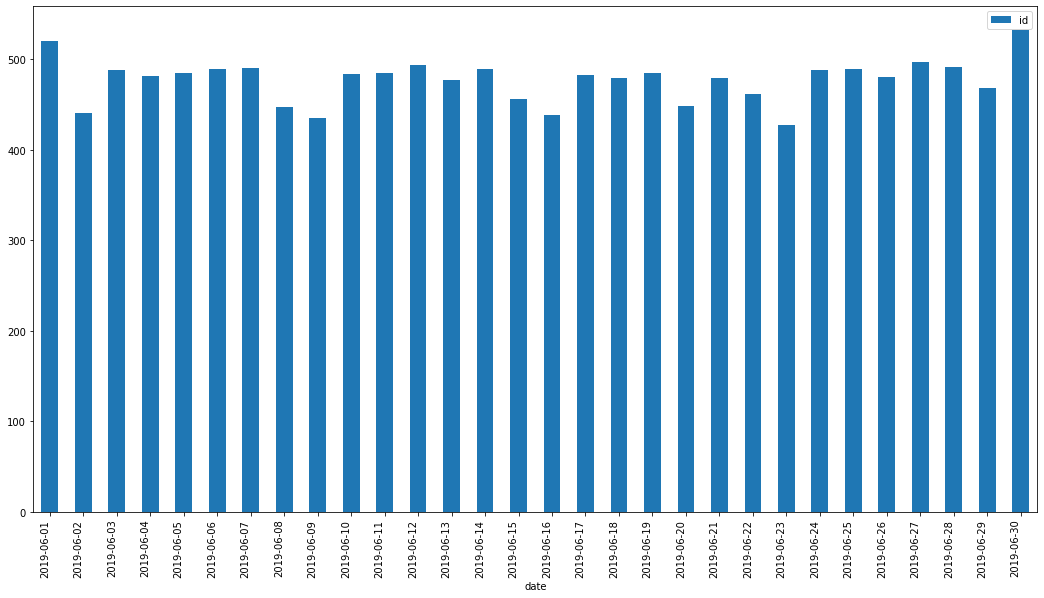

In [45]:
fig, ax = plt.subplots()
df_id_foreach_date.plot(ax=ax, kind='bar', legend=False, figsize=(18,9))
fig.autofmt_xdate(bottom=0.1, rotation=90)
ax.legend(loc='best')
#plt.savefig('df_id_foreach_date.png')

##### 3.1.3 Count the number of trajectories for each day of the week

In [46]:
df_id_foreach_day = df.loc[:,['day', 'id']].groupby(['id','day']).count().reset_index().groupby(['day']).count().reset_index().sort_values(['id'], ascending=False)
df_id_foreach_day.head(7)
# to save in csv

/Users/nickssonarrais/opt/anaconda3/envs/tnz/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,day,id


In [47]:
df_id_foreach_day.set_index(['day'], inplace=True)

TypeError: no numeric data to plot

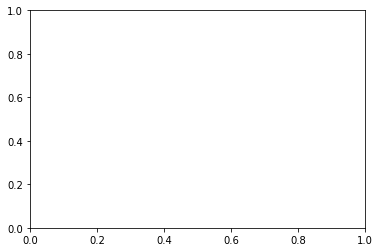

In [48]:
fig, ax = plt.subplots()
df_id_foreach_day.plot(ax=ax, kind='bar', legend=False, figsize=(18,9))
fig.autofmt_xdate(bottom=0.3, rotation=60)
ax.legend(loc='best')
plt.savefig('Count the number of trajectories for each day of the week.png')

In [53]:
df.head()

,id,segment_stop,datetime,lat,lon,stop,event_id,event_type,dist_cvp,Home,...,Farmácia,Loja de Bicicleta,Loja de Eletrônicos,Oficinas,Courthouse,Forum,police,Presidio,tid,date
0,M00038,1,2019-06-01 00:01:08,-3.76128,-38.512562,False,4636487,ROUBO DE VEÍCULO,4694.6540,5.615985,...,594.763013,813.104325,181.362425,315.824056,1378.026735,3245.412483,442.072751,15364.061617,M0003820190601,2019-06-01
31,M00038,11,2019-06-01 23:02:07,-3.76123,-38.512581,True,4639254,ROUBO DE VEÍCULO,6781.5894,5.796893,...,589.098648,810.051283,180.543226,311.029429,1375.594667,3239.931453,447.746155,15369.765152,M0003820190601,2019-06-01
30,M00038,10,2019-06-01 23:01:07,-3.76103,-38.512569,False,4639254,ROUBO DE VEÍCULO,6766.5960,23.723127,...,566.936819,791.657199,169.505619,289.274528,1376.701720,3217.668384,463.475562,15391.882110,M0003820190601,2019-06-01
29,M00038,9,2019-06-01 22:58:07,-3.76122,-38.512589,False,4639254,ROUBO DE VEÍCULO,6780.2017,6.817090,...,587.987284,809.653186,180.683184,310.186299,1374.808577,3238.879006,449.064170,15370.891025,M0003820190601,2019-06-01
28,M00038,9,2019-06-01 22:55:07,-3.76124,-38.512600,False,4639254,ROUBO DE VEÍCULO,6780.9062,7.578465,...,590.189431,812.112603,182.752523,312.644187,1373.731284,3241.164499,448.178324,15368.716414,M0003820190601,2019-06-01


### 3.2 To Speed

In [55]:
trajutils.transform_speed_from_ms_to_kmh(df, 'speed_to_prev')

###### Check the speeds greater than 180km/h

In [61]:
df_speed = df[df['speed_to_prev'] >= 180].loc[:,['id', 'speed_to_prev']].sort_values(['speed_to_prev'], ascending=False)
df_speed.head()
#df_speed.to_csv('ids_speed_greater_than_180kmH.csv', index=False, float_format='%.3f', decimal=',')

,id,speed_to_prev
964065,M07441,362.198484
77376,M00536,191.724163
1716728,M13269,183.670909


###### Check the COUNT and SUM for speed more than 180 KM/H

In [ ]:
df_speed.groupby('id').agg({'sum', 'count'}).sort_values('id').head()
#.to_csv('ids_speed_greater_than_180kmH_COUNT_SUM.csv', float_format='%.3f', decimal=',')

###### Check speed max by id to each date

In [ ]:
df.groupby(['id', 'date'])['speed_to_prev_kmH'].max().reset_index().sort_values(['date'])
#.to_csv('speed-max-per_date.csv',  float_format='%.3f', decimal=',')

### 3.3 To Jumps

###### Check the jumps larger than 3 km

In [ ]:
trajutils.transform_dist_from_meters_to_kilometers(df, trajutils.gl_label_dist_to_prev)

In [ ]:
df_jump = df[df['dist_to_prev_km'] > 3].loc[:, ['id', 'dist_to_prev_km', 'tid']].sort_values(['dist_to_prev_km'], ascending=False)
df_jump.head()
#df_jump.to_csv('jumps_larger_than_3_km.csv', index=False, float_format='%.3f', decimal=',')

###### Check the count and sum to jumps larger than 3 km

In [ ]:
df_jump.groupby(['id']).agg({'sum', 'count'}).sort_values(['id']).head()
#.to_csv('jumps_larger_than_3_km_COUNT_SUM.csv', float_format='%.3f', decimal=',')

### 3.4 To distances

In [ ]:
pandasutils.transform_time_from_seconds_to_minutes(df, trajutils.gl_label_time_to_prev)

###### Check  Odometers  to each id that traveled more than 1000km

In [ ]:
df_odometer = df.loc[:,['id','dist_to_prev_km', 'time_to_prev_m']].groupby(by=['id']).sum().sort_values(['dist_to_prev_km'], ascending=False).reset_index()
df_odometer.head()
#df_odometer.to_csv('odometers_to_each_id_that_traveled_more_than_1000km.csv', float_format='%.3f', decimal=',')

### 3.5 To Acceleration

###### Check  acceleration more higher than 10800km/h

In [ ]:
10800/3.6

In [ ]:
df['acceleration'] = df['speed_to_prev_kmH'] / (df['time_to_prev_m'] / 60)

In [ ]:
df_acceleration = df[df['acceleration'] >= 10800].loc[:,['id', 'acceleration']].sort_values(['acceleration'], ascending=True)
df_acceleration.head()
#df_acceleration.to_csv('acceleration_more_higher_than_10800kmH.csv', float_format='%.3f', decimal=',')

In [ ]:
df_acceleration.groupby(['id']).agg({'sum', 'count'}).sort_values(['id'])
#.to_csv('acceleration_more_higher_10800_COUNT_SUM.csv', float_format='%.3f', decimal=',')

### 3.6 Important features for each date

In [ ]:
dates = df['date'].unique()

for dt in dates:
    df[df['date'] == dt].groupby(['id']).sum().reset_index().to_csv(str(dt)+".csv", float_format='%.3f', decimal=',')

### 3.7 Important features for each day of week

In [ ]:
days = df['day'].unique()
for day in days:
    df[df['day'] == day].groupby(['id']).sum().reset_index().to_csv(str(day)+".csv", float_format='%.3f', decimal=',')

### 3.8 Important features to each period of the day

In [ ]:
periods = df['period'].unique()
for period in periods:
    df[df['period'] == period].groupby(['id']).sum().reset_index().to_csv(str(period)+".csv", float_format='%.3f', decimal=',')

### 3.9 Stop and Move

#### Check stops

In [ ]:
df_stop = df[df['situation_0'] == 'stop']

##### Count stop by id and sum time

In [ ]:
df_stops_by_id = df_stop.groupby(['id']).agg({'situation_0':'count', 'time_to_prev_m': 'sum'}).sort_values(['situation_0'], ascending=False)
df_stops_by_id.to_csv('COUNT_stops_by_id_and_SUM_time.csv', float_format='%.3f', decimal=',')

##### Count  Stops by id for each date

In [ ]:
df_stop_id_to_each_date = df_stop.loc[:,['id', 'date', 'situation_0']].groupby(['id', 'date']).count().sort_values(['date'])
df_stop_id_to_each_date.to_csv('COUNT_Stops_by_id_for_each_date.csv', float_format='%.3f', decimal=',')

##### Count stops by ids for each day of the week

In [ ]:
df_stop_id_to_each_day = df_stop.loc[:,['id', 'day', 'situation_0']].groupby(['day', 'id']).count().reset_index()
df_stop_id_to_each_day.to_csv('COUNT_stop_by_id_for_each_day.csv', float_format='%.3f', decimal=',')

##### Plot total time to stop and move

In [ ]:
label = 'situation_0'
time_total = df.loc[:,'time_to_prev_m'].sum(axis = 0, skipna = True)
time_move = df[df[label] == 'move'].loc[:,'time_to_prev_m'].sum(axis = 0, skipna = True)
time_stop = df[df[label] == 'stop'].loc[:,'time_to_prev_m'].sum(axis = 0, skipna = True)

plt.figure(figsize=(9, 6))

bars = plt.bar(['time_total', 'time_move', 'time_stop'], [round(time_total/time_total*100, 4), round(time_move*100/time_total, 4), round(time_stop*100/time_total, 4)], align='center', color="blue")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval, va='bottom', fontsize=14)


plt.savefig('total_move_and_stop_'+str(label)+'.png',dpi=400)

##  4 Bbox

###### Filter the number of prisoners who left Fortaleza

In [ ]:
## 4 Bbox
bbox_fortaleza = [-3.90, -38.67, -3.68, -38.38]
df_bbox_out = trajutils.filter_bbox(df, bbox_fortaleza, filter_out=True, inplace=False)
print('Number of prisoners: {}\nTotal number of prisoners out Fortaleza: {}'.format(df['id'].nunique(), df_bbox_out['id'].nunique()))
df_bbox_out.head()

###### Check the prisoners who stayed for a longer time outside Fortaleza

In [ ]:
df_bbox_out_time = df_bbox_out.groupby(['id']).agg({'time_to_prev_m':'sum'}).sort_values(['time_to_prev_m'], ascending=False).reset_index()
df_bbox_out_time.to_csv('ids_longer_time_outside_Fortaleza.csv', float_format='%.3f', decimal=',')